<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/object_detection/vehichile_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construction Vehicle Detection with DEtection TRansformer DETR

Train the transformer-based object detection model DETR on Hugging Face [excavator-detector dataset](!https://huggingface.co/datasets/keremberke/excavator-detector) to identifie construction vehicles like excavators, dump trucks, and wheel loaders using camera images

In [ ]:
!pip install datasets transformers

In [ ]:
!pip install albumentations

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install evaluate

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


## 1. Load and split a Hugging Face construction vehicle dataset



In [7]:
from datasets import load_dataset
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

ds = load_dataset("keremberke/excavator-detector", name="full")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

excavator-detector.py:   0%|          | 0.00/5.84k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2245 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/267 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/144 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2245
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 267
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 144
    })
})

sample content:
image_id: 2077
image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7859ED76D290>
width: 640
height: 640
objects: {'id': [2965, 2966, 2967, 2968], 'area': [675, 548, 2760, 7797], 'bbox': [[330.0, 354.0, 22.5, 30.0], [357.0, 369.0, 21.5, 25.5], [227.0, 354.0, 40.0, 69.0], [516.0, 360.0, 69.0, 113.0]], 'category': [0, 0, 0, 0]}



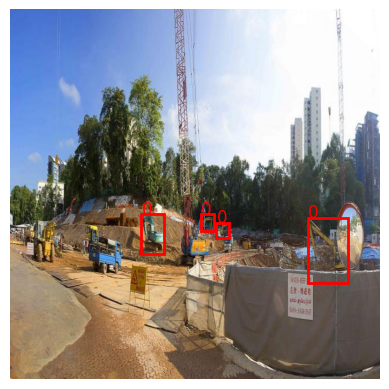

In [7]:
import random

rand_inx = random.randint(0, len(ds["train"]) - 1)
example = ds['train'][rand_inx]

# display example content
print(f"sample content:")
for key, value in example.items():
    print(f"{key}: {value}")

# display image
print()
plt.imshow(example['image'])
plt.axis("off")

# draw bounding boxes and category labels
ax = plt.gca() # gets the current Axes(area whitin the plot where image and annotations are displayed) object

# a loop though each detected object bounding box with coordinates x, y, width and height
# draw the their outlines on the image, retrive and add cotegory label
for i in range(len(example['objects']['bbox'])):
  bbox = example['objects']['bbox'][i]
  x, y, w, h = bbox
  rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  ax.add_patch(rect)

  plt.text(x, y, str(example['objects']['category'][i]), color='r', fontsize=12)


plt.show()

### Vehicle categorie names in dataset

In [ ]:
# the feature metadata of the object column in the split contains the vehichle's categories
ds['train'].features['objects'].feature['category'].names

['excavators', 'dump truck', 'wheel loader']

In [8]:
# get unique category IDs
unique_category_ids = set()
for split in ds:  # Iterate through 'train', 'test'
    for example in ds[split]:
        unique_category_ids.update(example['objects']['category'])

# create mappings between category indices and labels
id2label = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)}
label2id = {v: k for k, v in id2label.items()}

print(f" ids to labels mapping: {id2label}")
print(f" labels to ids mapping: {label2id}")
print()
# print category names
print("Object Category Names:")
for category_id in unique_category_ids:
    category_name = id2label.get(category_id, "Unknown")  # handle unknown IDs
    print(f"- {category_name}")

 ids to labels mapping: {0: 'excavators', 1: 'dump truck', 2: 'wheel loader'}
 labels to ids mapping: {'excavators': 0, 'dump truck': 1, 'wheel loader': 2}

Object Category Names:
- excavators
- dump truck
- wheel loader


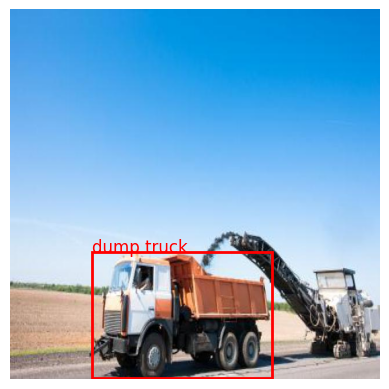

In [9]:
rand_inx = random.randint(0, len(ds["train"]) - 1)
example = ds['train'][rand_inx]

# display image with detected object category names
print()
plt.imshow(example['image'])
plt.axis("off")

# draw bounding boxes and category labels
ax = plt.gca()

# a loop though each detected object bounding box
for i in range(len(example['objects']['bbox'])):
  bbox = example['objects']['bbox'][i]
  x, y, w, h = bbox
  rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  ax.add_patch(rect)
  category_id = example['objects']['category'][i]
  category_name = id2label.get(category_id, "Unknown")
  plt.text(x, y, category_name, color='r', fontsize=12)


plt.show()

## 2. Preprocess dataset

* Resize the data to apply data augmentations.
* Format the annotations to convert them to Coco-compatible ones.
* Load a Transformer based object detection model check point (for DETR).
* Instantiate an image processor using the checkpoint.
* Append the images and annotations into lists and pass them through the image processor.

### Augment images and convert bounding boxes into COCO

**Comon Object in COntext** format is [x_min, y_min, width, height]
where x_min and y_min are the coordinates of the bottom-left corner of the bounding box.
width and height are the dimensions of the bounding box.The [COCO dataset class](https://www.v7labs.com/blog/coco-dataset-guide) is a image recognition dataset for object detection, segmentation and captioning tasks. The dataset has two main parts: the images and their annotations. The images are organized into directories contiainig train, validation and test sets, and the annotations are provided in JSON format, with each file corresponding to a single image.

In [ ]:
import albumentations # augment images and bozes using Albumentations package
import numpy as np
import torch

# define the transformation
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),  # always flip the image horizontally
        albumentations.RandomBrightnessContrast(p=1.0),  # always adjust brightness and contrast
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),  # handle bounding boxes in COCO format
)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Format Annotations into COCO

In [ ]:
def format_annot(image_id, categories, areas, bboxes):

  """ Format annotations into COCO format of a given image with image_id, list of category ids
      list of area ids, and a list of bounding boxes, returning a formatied list of annotations."""

  annotations = []
  for i in range(0, len(categories)):
    new_ann = {
            "image_id": image_id,
            "category_id": categories[i],
            "isCrowd": 0,
            "area": areas[i],
            "bbox": list(bboxes[i]),
        }
    annotations.append(new_ann)

  return annotations


### Image-processor

In [ ]:
# instantiate an image processor
from transformers import DetrImageProcessor #AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = DetrImageProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [ ]:
all_attributes = dir(image_processor)

# Filter for methods (callable attributes)
methods = [attr for attr in all_attributes if callable(getattr(image_processor, attr))]

# Print the methods
print("Available methods for image_processor:")
for method in methods:
    print(f"- {method}")

Available methods for image_processor:
- __call__
- __class__
- __delattr__
- __dir__
- __eq__
- __format__
- __ge__
- __getattribute__
- __getstate__
- __gt__
- __hash__
- __init__
- __init_subclass__
- __le__
- __lt__
- __ne__
- __new__
- __reduce__
- __reduce_ex__
- __repr__
- __setattr__
- __sizeof__
- __str__
- __subclasshook__
- _create_repo
- _get_files_timestamps
- _pad_image
- _set_processor_class
- _update_annotation_for_padded_image
- _upload_modified_files
- center_crop
- fetch_images
- from_dict
- from_json_file
- from_pretrained
- get_image_processor_dict
- normalize
- normalize_annotation
- pad
- post_process
- post_process_instance
- post_process_instance_segmentation
- post_process_object_detection
- post_process_panoptic
- post_process_panoptic_segmentation
- post_process_segmentation
- post_process_semantic_segmentation
- prepare_annotation
- preprocess
- push_to_hub
- register_for_auto_class
- rescale
- resize
- resize_annotation
- save_pretrained
- to_dict
- to_jso

### Prepare images and their annotations for object detection training

In [ ]:
def transform_augment(example):
  """ The function takes an example dictionary as input, which contains image data
      and object annotations, and it transformes them with a pre-defined transform
      function, iterating through each image and formatting annotations in the example."""

  image_id = example['image_id']
  images, bboxes, areas, categories = [], [], [], []

  for image, objects  in zip(example["image"], example["objects"]):
    # convert the image to RGB and reverse the color channel
    image = np.array(image.convert("RGB"))[:, :, ::-1]
    # aplly transformation to the image and augmentation of the
    out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
    # append transformed and augmented data to the respective lists
    areas.append(objects["area"])
    images.append(out["image"])
    bboxes.append(out["bboxes"])
    categories.append(out["category"])
  # use list comprehention to iterate through the lists to format the annotations
  targets = [
        {"image_id": id,
         "annotations": format_annot(id, cat, ar, box)}
        for id, cat, ar, box in zip(image_id, categories, areas, bboxes)
  ]
  # pre-process with image_processor
  example = image_processor(images=images, annotations=targets, return_tensors="pt")

  return example


In [ ]:
ds["train"] = ds["train"].with_transform(transform_augment)
ds["train"][0]

## 3. Batch images and masks

In transformer-based models like DETR, the attention mechanism is used to focus on important parts of the image. The pixel mask helps the attention mechanism to ignore padded areas, preventing the model from attending to irrelevant information. Pixel mask also ensures that the loss is only computed for valid pixels

In [34]:
def collate_func(batch):
  """ Prepares the batched data for dataloader input to transformer-based object detection model
  by taking a list of samples and combining them into a dictionatry that can be fed to
  the model."""

  # extract the pizel values and the ground truth annoataions
  pixel_values = [item['pixel_values'] for item in batch]
  labels = [item['labels'] for item in batch]
  # use image procesor to pad and create a pixel mask
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  # extract labels from each item in the batch
  labels = [item["labels"] for item in batch]

  batch = {}
  # combine image data, pixel masks, and labels into a single dictionary
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels

  return batch

## 4. Load and train DETR

In [ ]:
from transformers import DetrForObjectDetection #AutoModelForObjectDetection

model = DetrForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

### Define training hyperparameters

In [15]:
from transformers import TrainingArguments

trainig_args = TrainingArguments(
    output_dir = "detr-resnet-50",
    per_device_train_batch_size = 8,
    num_train_epochs = 10,
    fp16 = True,
    save_steps = 20,
    logging_steps = 10,
    learning_rate = 1e-5,
    weight_decay = 1e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = True,
    #hub_token = "xxxxxxx"
)

### Pass training arguments to Trainer

In [16]:
import accelerate
import inspect

# Get the signature of the Accelerator.__init__ method
signature = inspect.signature(accelerate.Accelerator.__init__)

# Print the parameters and their default values
print("Input Parameters for accelerate.Accelerator():")
for param in signature.parameters.values():
    print(f"  - {param.name}: {param.default}")

Input Parameters for accelerate.Accelerator():
  - self: <class 'inspect._empty'>
  - device_placement: True
  - split_batches: <object object at 0x7b6a8c405ee0>
  - mixed_precision: None
  - gradient_accumulation_steps: 1
  - cpu: False
  - dataloader_config: None
  - deepspeed_plugin: None
  - fsdp_plugin: None
  - megatron_lm_plugin: None
  - rng_types: None
  - log_with: None
  - project_dir: None
  - project_config: None
  - gradient_accumulation_plugin: None
  - step_scheduler_with_optimizer: True
  - kwargs_handlers: None
  - dynamo_backend: None
  - dynamo_plugin: None
  - deepspeed_plugins: None


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import accelerate

# Create a DataLoader for your training dataset
train_dataloader = DataLoader(
    ds["train"],
    batch_size = trainig_args.per_device_train_batch_size,
    collate_fn = collate_func,
)

# Initialize the accelerator
accelerator = accelerate.Accelerator(mixed_precision='fp16')

# Prepare the model, optimizer, and dataloader for distributed training
model, optimizer, train_dataloader = accelerator.prepare(
    model, torch.optim.AdamW(model.parameters(), lr=trainig_args.learning_rate), train_dataloader
)

# Training loop
for epoch in range(trainig_args.num_train_epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        # Move data to the appropriate device
        pixel_values = batch["pixel_values"].to(accelerator.device)
        pixel_mask = batch["pixel_mask"].to(accelerator.device)
        labels = [{k: v.to(accelerator.device) for k, v in t.items()} for t in batch["labels"]]

        # Forward pass
        outputs = model(pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Save the model at the end of each epoch
    if trainig_args.should_save:
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(trainig_args.output_dir, save_function=accelerator.save)

In [ ]:
model.save_pretrained("detr_vechile_detection")

### Upload to Hugging Face Hub

In [ ]:
# upload trained model to Huggingface Hub
#model.push_to_hub()

## 5. Evaluate the model

* Format the annotations of the test dataset
* Save the images and annotations into the expected format for torchvision.datasets.CocoDetection
* Prepare an instance of a CocoDetection class that can be used with cocoevaluator
* Load metrics and run the evaluation
* Load an image from the test dataset
* Run inference on the image using the trained model.
* Display the predicted object bounding boxes overlaid on the image with the object class

In [18]:
from transformers import DetrForObjectDetection

# load trained model weigths
trained_model = DetrForObjectDetection.from_pretrained("detr_vechile_detection")

### Format Annotation of Test Dataset

In [19]:
from torchvision.datasets import CocoDetection
import inspect

# Get the signature of the CocoDetection class
signature = inspect.signature(CocoDetection)

# Print the parameters and their default values
print("Input Parameters for torchvision.datasets.CocoDetection():")
for param in signature.parameters.values():
    print(f"  - {param.name}: {param.default}")

# print the annotations
print("\nannotations:")
for param in signature.parameters.values():
    if param.annotation is not inspect.Parameter.empty:
        print(f"  - {param.name}: {param.annotation}")


Input Parameters for torchvision.datasets.CocoDetection():
  - root: <class 'inspect._empty'>
  - annFile: <class 'inspect._empty'>
  - transform: None
  - target_transform: None
  - transforms: None

annotations:
  - root: typing.Union[str, pathlib.Path]
  - annFile: <class 'str'>
  - transform: typing.Optional[typing.Callable]
  - target_transform: typing.Optional[typing.Callable]
  - transforms: typing.Optional[typing.Callable]


In [20]:
def val_format_annot(image_id, objects):
  """ Function that format image annotations. It takes an image id and a dictionary
  of objects as input and structures that information into a COCO standard. """

  annotations = []
  #loop over the the number of objects detected in object dictionary
  for i in range(0, len(objects['id'])):
    new_ann = {
            "image_id": image_id,
            "category_id": objects['category'][i],
            "iscrowd": 0,
            "area": objects['area'][i],
            "bbox": list(objects['bbox'][i]),
        }
    annotations.append(new_ann)
  # return the list of COCO=formated annotations for all detected objects in an image
  return annotations

### Save images and annotations into COCO Detection format

In [21]:
import os
import json

def save_annotation_file_image(dataset, output_dir="coco_data"):
    """ Saves dataset images and annotations into an output_dir in file format
        expected by torchvision.datasets.CocoDetection -  a tuple containing
        the path to the JSON annotation file and the output directory. """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images_data = []
    annotations_data = []
    annotation_id = 0  # initialize annotation ID

    for i, example in enumerate(dataset):
        image_id = i  # use index as image ID
        image_path = os.path.join(output_dir, f"image_{image_id}.jpg") # xample file name

        example["image"].save(image_path)

        image_data = {
            "id": image_id,
            "file_name": f"image_{image_id}.jpg",
            "height": example["image"].height,
            "width": example["image"].width
        }
        images_data.append(image_data)

        for j in range(len(example['objects']['category'])):
          annotation = {
                "id": annotation_id,
                "image_id": image_id,
                # access category as an integer using its index
                "category_id": int(example['objects']['category'][j]),
                "bbox": example['objects']['bbox'][j],
                "area": example['objects']['area'][j],
                "iscrowd": 0,
            }


          annotations_data.append(annotation)
          annotation_id += 1

    coco_format_data = {
        "images": images_data,
        "annotations": annotations_data,
        "categories": [{"id": i, "name": name} for i, name in id2label.items()]  # Add categories
    }

    json_file_path = os.path.join(output_dir, "annotations.json")

    with open(json_file_path, "w") as f:
        json.dump(coco_format_data, f)

    # save each image
    for image, image_id in zip(dataset["image"], dataset["image_id"]):
        image_path = os.path.join(output_dir, f"image_{image_id}.jpg")
        image.save(image_path)

    return json_file_path, output_dir

### COCO Detection class to be used with COCO Evaluator

In [22]:
import torchvision
# PyTorch has a COCO Detection class which is expanded and used with cocoevaluator
class CocoDetection(torchvision.datasets.CocoDetection):

    def __init__(self, img_folder, image_processor, annot_file):
      # pass the image and annotation dirs to the superclass
        super(CocoDetection, self).__init__(img_folder, annot_file)
        self.image_processor = image_processor
        # coco attribute is inherited from the parent class torchvision.datasets.CocoDetection
        # it's an instance of the pycocotools.coco.COCO class, which is responsible
        # for loading and parsing the COCO annotation file annot_file

    def __getitem__(self, idx):
        # read in image and target
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        # converting target to DETR format, resize and normalize image and target
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        # remove batch dimension
        pixel_values = encoding["pixel_values"].squeeze()
        # remove batch dimension
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

In [23]:
from datasets import load_dataset

ds = load_dataset("keremberke/excavator-detector", name="full")
ds['test'].features['objects'].feature['category'].names

id2label = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)}
label2id = {v: k for k, v in id2label.items()}

In [53]:
from transformers import DetrImageProcessor

# custom weights
checkpoint = "detr_vechile_detection"
image_processor = DetrImageProcessor.from_pretrained(checkpoint)

# Save the image processor configuration to existing model directory
image_processor.save_pretrained("detr_vechile_detection")

['detr_vechile_detection/preprocessor_config.json']

In [30]:
from transformers import DetrImageProcessor

# image processor configuration with checkpoints used for trianing
image_processor = DetrImageProcessor.from_pretrained("detr_vechile_detection")

# save the test data annotations in COCO format
output_path, annot_path = save_annotation_file_image(ds["test"], output_dir="coco_data")

print(output_path)
print(annot_path)

# create an instance of the custom dataset class using CocoDetection class
test_coco_dataset = CocoDetection(
    img_folder = "coco_data",
    image_processor = image_processor,
    annot_file = output_path
)

# The test_coco_dataset object is used to load and preprocess the test data for
# evaluation using COCO standard

coco_data/annotations.json
coco_data
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Evaluate model on test dataset

In [61]:
import evaluate
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the COCO evaluation metric with gtound truth annotation in COCO format
module = evaluate.load("ybelkada/cocoevaluate", coco=test_coco_dataset.coco)

print(type(module))
print(module)

# create a test loader
val_dataloader = DataLoader(
    test_coco_dataset,
    batch_size = 8,
    shuffle = False,
    num_workers = 2,
    collate_fn = collate_func)


<class 'evaluate_modules.metrics.ybelkada--cocoevaluate.30942fed7a012a63461cc45b56b2b32ffc60b69257c2531bdd123b63bde5c3f5.cocoevaluate.COCOEvaluate'>
EvaluationModule(name: "coco_evaluate", module_type: "metric", features: {'predictions': [{'scores': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None)}], 'references': [{'size': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), 'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'orig_size': Sequence

In [63]:
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):

        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # These are in DETR format, resized + normalized

        # Forward pass
        outputs = trained_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)

        results = image_processor.post_process(outputs, orig_target_sizes)  # convert model outputs to COCO API format

        # Add predictions and references to the evaluation module
        module.add(prediction=results, reference=labels)
        # delete current batch of data after processing to free up memory
        del batch


  0%|          | 0/18 [00:00<?, ?it/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
100%|██████████| 18/18 [08:13<00:00, 27.39s/it]


In [64]:
# compute evaluation metric based on the prediction and ground truth
results = module.compute()
print(results)

Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

### Inference on a image

In [48]:
from transformers import DetrForObjectDetection, DetrImageProcessor

trained_model = DetrForObjectDetection.from_pretrained("detr_vechile_detection")
image_processor = DetrImageProcessor.from_pretrained("detr_vechile_detection")

id2label = trained_model.config.id2label
label2id = trained_model.config.label2id

In [55]:
import random
# slect a random test image
rand_inx = random.randint(0, len(ds["test"]) - 1)
image = ds["test"][rand_inx]["image"]
#image = ds["test"][16]["image"]

In [56]:
# perform inference on input image
with torch.no_grad():
  # preprocess the image
  inputs = image_processor(images=image, return_tensors="pt")
  # forward pass through the object detection
  outputs = trained_model(**inputs)
  # set terget size for postprocessing
  target_sizes = torch.tensor([image.size[::-1]])
  # post-process the outputs
  results = image_processor.post_process_object_detection(
      outputs,
      threshold=0.4,
      target_sizes=target_sizes)[0]

# print the detected objects with confidence score and bounding boxes coordinates
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
  box = [round(i, 2) for i in box.tolist()]
  print(
      f"Detected {trained_model.config.id2label[label.item()]} with confidence "
      f"{round(score.item(), 3)} at location {box}"
  )

Detected wheel loader with confidence 0.45 at location [0.6, 52.08, 593.01, 624.1]


In [57]:
results

{'scores': tensor([0.4505]),
 'labels': tensor([2]),
 'boxes': tensor([[6.0301e-01, 5.2081e+01, 5.9301e+02, 6.2410e+02]])}

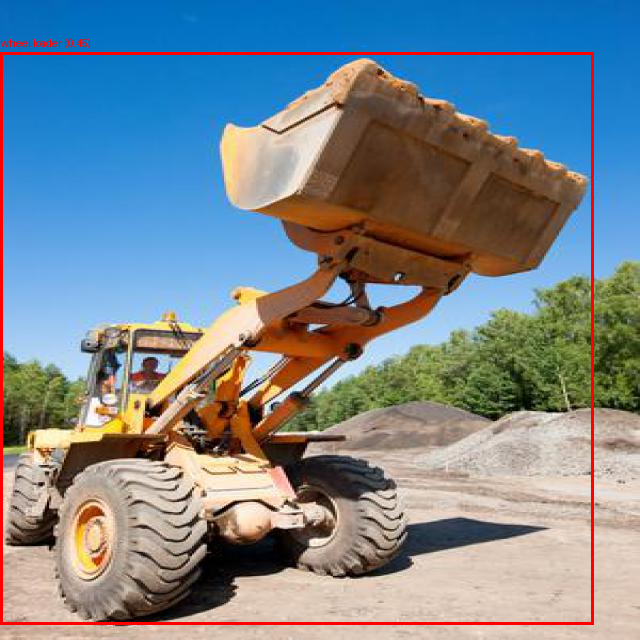

In [58]:
# create a drawing object  draw = ImageDraw.Draw(image) to visualize the detection results on the input image
from PIL import ImageDraw
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)  # draw bounding box
    draw.text((x_min, y_min - 15), f"{id2label[label.item()]} ({round(score.item(), 2)})", fill="red") # add label and confidence

image